# First pass analysis of line/loop data

<ul>
    <li> Analyse correct sequence lengths. </li>
    <li> Do reaction times </li>
    <li> Analyse as a function of distance from reward </li>
    <li> Try to fit RL model to these data </li> 
    
</ul>

<b> WHY IS THERE A DIFFERENCE BETWEEN REW_LIST AND DAT_DICT['STATE'] </b>

In [251]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime

sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/yves/Documents/Code/line_loop/packages/")

In [252]:
import mouse_poker as mpk

# Defined functions 

In [253]:
#physical position of the pokes. In terms of numbering, the pokes are numbered as follows
#(or in some cases the indexing starts from 0 rather than 1)

"""
     1
   2   3
 4   5   6 
   7   8
     9
"""

#physical positions of the pokes, used for drawing the graphs
#with nodes and edges. The distances here are to scale with
#the real thing.
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [254]:
from mouse_poker.navi import *

In [255]:
def get_performance(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=5,set_rew_indices=None,firstOnly=False,maxNrew=100):
    
    """ 
    Calculate the fraction correct in each state
    
    Arguments:
    ============================
    
    state_seq (list):             The sequence of states visited by the subject
    
    rew_list (list):              A boolean list that specifies whether a reward was received at this location or not
    
    port_seq (list):              The sequence of ports visited by the subject
    
    forced_seq (list):            A boolean list that specifies whether the decision the animal made was forced
    
    map_poke_to_state (function): Takes as input a port and returns the state this port corresponds to
    
    rew_indices (list):           The set of states (not ports!) where in this session rewards were delivered
    
    minNrew (int):                The required minimum number of sequential rewards at a particular rewarded state
                                  that are required before they are included in the perf and and perf_ctr arrays.
                                  For calculating the fraction correct, for example, you may want to ignore the first
                                  trial, when the animal doesn't know where the reward is
                                  
    minNrew (int):                Analogous to minNrew but specifies an upper limit
    
    set_rew_indices (list):       If you only want to consider behaviour when the reward is in one of 
                                  a particular set of states, rather than all states that had reward in
                                  a particular session, you can specify this parameter.
                                  
    first_only (boolean):         If True, for each trial (i.e. from a given starting state to receiving the reward)
                                  then it only adds the decision you make during the first visit to each state on that
                                  trial. For example, if reward is at 5 and the state sequence is 3-4-3-4-5. It will
                                  say that you made 1 correct decision in state 3 and 1 incorrect decision in state 4.
                                  Otherwise, you would have 2 correcy decisions in state 3, 2 incorrect in state 4 and
                                  1 correct in state 4.
                                    
    """
    
    used_states = sorted([i[1] for i in map_poke_to_state.args[0]])  #
    if set_rew_indices is None: set_rew_indices=used_states
    perf = np.zeros([9,9])  #this is an array that keeps track of the number of correct choices made in each state at each possible reward location
    perf_ctr = np.zeros([9,9]) #this is an array that keeps track of the TOTAL number choices made in each state at each possible reward location
    rew_hist = []
    all_rew_loc = []
    
    #the main logic of this code is to use the rew_list to separate the state sequence into trials.
    #and then calculate things on a trial by trial basis.
    for rew_ctr,(st,nd) in enumerate(zip(np.where(rew_list)[0][:-2],np.where(rew_list)[0][1:-1])):
        
        
        rew_loc = state_seq[nd]   #the reward location on this trial
        
        #include this trial only if it is at one of the reward locations you are considering
        if (rew_loc in set_rew_indices):
            
            #This block of code is used to calculate the number of
            #sequential rewards at the same location
            all_rew_loc.append(rew_loc)
            if not rew_hist:
                rew_hist.append(rew_loc)
            elif rew_loc==rew_hist[-1]:
                rew_hist.append(rew_loc)
            else:
                rew_hist = []

            has_visited= []  #this is a list of states that you have visited in a given 'trial', relevant if first_only=True
            
            #If you are in the range of number of rewards of interest calculate stuff in the trial
            if np.logical_and(len(rew_hist)>=minNrew,len(rew_hist)<=maxNrew): 
                
                #for each poke in the trial
                for pk_ctr in range(st+1,nd+1):
                    rewarded = rew_list[pk_ctr]  #if it is rewarded. Offset by 1 index (i.e. if the sequence is 3-4-5).
                    

                    #only proceed if it is NOT a forced trial
                    if not forced_seq[pk_ctr]:
                        
                        d0 = np.abs(state_seq[pk_ctr]-rew_loc)     #calculate the distance, in state space, from the current state to the reward 
                        d1 = np.abs(state_seq[pk_ctr+1]-rew_loc)   #calculate the distance, in state space, from the NEXt state to the reward

                        state = state_seq[pk_ctr]
                        rewarded = rew_list[pk_ctr]  #if it is rewarded. Offset by 1 index (i.e. if the sequence is 3-4-5).

                        
                        if state not in has_visited: #if this is the first visit to the state (note if first_only=False, you don't store which states you have visited)
                            
                            if d1<d0:   #if the distance of the next state from reward is smaller than the current state you made the correct choice
                                perf[state,rew_loc] += 1
                                perf_ctr[state,rew_loc] += 1
                            else:        #you made the wrong choice
                                perf[state,rew_loc] += 0
                                perf_ctr[state,rew_loc] += 1
                            if firstOnly: has_visited.append(state)
    
    for i in np.unique(rew_hist):
        perf[i,i] = np.nan
        perf_ctr[i,i] = np.nan

    return perf, perf_ctr

# Actual code to run stuff 

In [256]:

#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-15-145534.txt",'r')
#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-01-110337.txt",'r')
f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'456675_10'-2021-02-23-142909.txt",'r')

lines =f.readlines()
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

print("rewards_received: {:d}".format(nRews))
print('task_nr:{:.0f}'.format(int(task_nr)))

rewards_received: 145
task_nr:2


In [257]:
len(rew_list)

1581

In [258]:
#Note this can lead to bugs at the moment because the way it works is 
#to use the visited pokes and states in the text file to work out the mapping
#however, if in a given session some state is not visited this can lead to 
#problems...
poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)  #construct function to map between pokes and states
used_states = sorted([i[1] for i in full_pkst_map])
used_pokes = ([i[0] for i in full_pkst_map])

map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

#rew_indices = [0,3,5,8]

#this looks through the entire text file
rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()


In [259]:
state_seq = [i[0] for i in dat_dict['state']]
poke_seq = [map_state_to_poke(i) for i in state_seq]
#dat_dict['rews']

In [260]:
np.sum(rew_list)

145

In [261]:
np.sum(dat_dict['rew_list'])

145

In [262]:
#this extracts the core information from the text file. This is key to work with
state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)

#this runs the main analysis that we have done so far.
perf,perf_ctr = get_performance(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=5)
fc = perf/perf_ctr  #calculate fraction correct at each point
print(np.nanmean(fc))

0.6674654666288576


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [236]:
dat_dict.keys()

dict_keys(['state', 'port', 'random', 'rew_locations', 'rews', 'rew_list'])

In [243]:
len(dat_dict['state'])

1436

In [242]:
len(state_seq)

1581

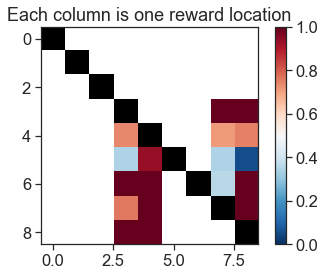

In [213]:
#plot the results of the above analysis
plt.title('Each column is one reward location')
rew_diag_mtx = np.dstack([np.eye(perf.shape[0])*-1 + 1]*3 + [np.eye(perf.shape[0])])
#fcplot = (perf/perf_ctr)
np.fill_diagonal(fc,np.nan)
plt.imshow(rew_diag_mtx,cmap='Greys')
plt.imshow(fc,vmin=0,vmax=1,cmap='RdBu_r')
#plt.xlim(.5,6.5); plt.ylim(6.5,.5)
plt.colorbar()

# Run as batch analysis the above 

In [216]:
#ROOT = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'
#ROOT = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_males/'
#ROOT = '/Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI_males/'
ROOT = '/Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'
#ROOT = '/Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI_toLOOP/'


fs = os.listdir(ROOT)
res_dict = {}
minNRew = 5
today = datetime.now()
allres = [[] for _ in range(20)]
for f_ in fs[-20:-10]:
        
    fpath = os.path.join(ROOT,f_)
    if os.path.isfile(fpath):
        subject = eval(re.findall("('.*')",f_)[0])
        #print(subject)

        t1_ = re.findall(r'(202.*)-[0-9]{6}.txt',f_)[0]
        t1_ = datetime.strptime(t1_,'%Y-%m-%d')
        
        if (now - t1_).days<=70:
            f = open(fpath,'r')
            lines =f.readlines()

            for mnr in range(5,6):
                experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
                dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
                subject = subject + '_' + str(task_nr)
                
                if nRews>20:

                    poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
                    used_states = sorted([i[1] for i in full_pkst_map])
                    used_pokes = ([i[0] for i in full_pkst_map])

                    map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
                    map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

                    #rew_indices = [0,3,5,8]
                    rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()
                    state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)
                    perf,perf_ctr = get_performance(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=mnr,maxNrew=mnr+100,firstOnly=False)
                    #if mnr>10:
                    #    print
                    allres[mnr].append(np.nansum(perf)/np.nansum(perf_ctr))

                    if subject not in res_dict.keys():
                        res_dict[subject] = [[perf,perf_ctr]]
                    else:
                        res_dict[subject].append([perf,perf_ctr])
            print(task_nr,fpath)

1 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'456675_10'-2021-03-02-132000.txt
2 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'460175_10'-2021-03-03-105405.txt
2 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'460175_10'-2021-03-15-145534.txt
2 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'456675_10'-2021-02-17-110616.txt
1 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'456675_10'-2021-03-05-110006.txt
2 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'460175_10'-2021-03-01-110337.txt
2 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'460175_10'-2021-03-02-142443.txt
1 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'456675_10'-2021-03-05-111657.txt
1 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'456675_10'-2021-03-05-105811.txt
1 /Users/yves/Downloads/line_loop_batch_4_2gra

2 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'456675_10'-2021-02-24-104759.txt
2 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'456675_10'-2021-02-22-112324.txt
1 /Users/yves/Downloads/line_loop_batch_4_2graphs/line_loop_batch_3NAVI/'460175_10'-2021-03-05-110147.txt


In [220]:
rew_list[:4]

[True, False, False, False]

In [221]:
port_seq[:4]

[4, None, 5, 7]

In [222]:
state_seq[:4]

[4, 8, 7, 8]

In [217]:
'456675_10'

'456675_10'

In [218]:
[np.nanmean(i) for i in allres]

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


[nan,
 nan,
 nan,
 nan,
 nan,
 0.5949161188569614,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


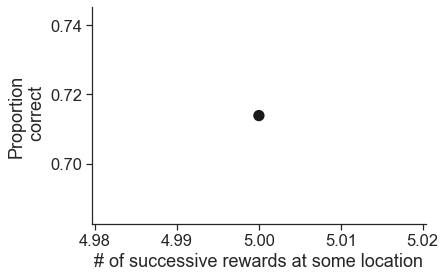

In [307]:
from scipy.ndimage import gaussian_filter1d
sess_perf = [np.nanmean(i) for i in allres]
plt.plot(gaussian_filter1d(sess_perf,2.25,mode='nearest'),linewidth=5)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=128,edgecolors='none')
plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion\n correct")
#plt.ylim(.6,.975)
seaborn.despine()

In [308]:
sess_perf = [np.nanmean(i) for i in perf_stuff]
plt.plot(gaussian_filter1d(sess_perf,2.25,mode='nearest'),linewidth=5)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=128,edgecolors='none')
plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion\n correct")
plt.ylim(.6,.975)
seaborn.despine()

NameError: name 'perf_stuff' is not defined

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


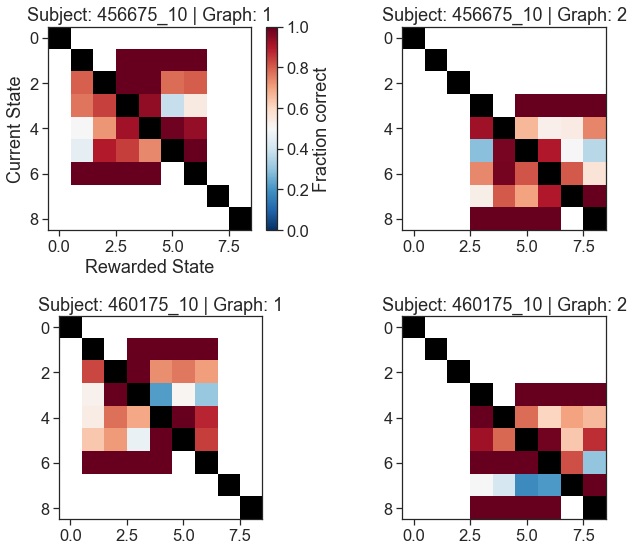

In [309]:
plt.figure(figsize=(10,8))
for ctr,subject in enumerate(res_dict.keys()):
    
    plt.subplot(2,2,ctr+1)
    plt.title("Subject: {} | Graph: {}".format(subject[:-2],subject[-1]))
    allp = np.nansum([i[0] for i in res_dict[subject]],axis=0)
    allp_ctr = np.nansum([i[1] for i in res_dict[subject]],axis=0)
    fc = (allp/allp_ctr)
    np.fill_diagonal(fc,np.nan)
    plt.imshow(np.dstack([np.eye(perf.shape[0])*-1 + 1]*3 + [np.eye(perf.shape[0])]),cmap='Greys')
    plt.imshow(fc,vmin=0,vmax=1,cmap='RdBu_r')
    
    if ctr==0:
        plt.xlabel("Rewarded State")
        plt.ylabel("Current State")
        cbar = plt.colorbar()
        cbar.set_label("Fraction correct")

plt.tight_layout()

# Other

In [315]:
st = np.min(np.where(np.nansum(perf,axis=1))[0]) - 1
nd = np.max((np.where(np.nansum(perf,axis=1))[0])) + 1


#these are the pokes used for reward in this session
used_rews = np.array([np.where(np.isnan(perf[:,i]))[0] for i in np.where(np.nansum(perf,axis=0))[0]]).flatten()
used_rew_cols = np.where(np.nansum(perf,axis=0))[0]

In [316]:
ix = used_rew_cols[0]
c_rew_index = ix

#good_edges = [[map_state_to_poke(0),map_state_to_poke(1)],
#              [map_state_to_poke(8),map_state_to_poke(7)]]
bad_edges = []
good_edges = []
for s in range(st-1,nd+1):
    if s!=c_rew_index and s in used_states:
        d1 = np.abs(c_rew_index-(s+1))  #distances of state above to reward
        d2 = np.abs(c_rew_index-(s-1))  #distance of state below to reward
        min_ = np.argmin([d1,d2])
        max_ = np.argmax([d1,d2])
        
        if [s+1,s-1][min_] in used_states:
            good_edges.append([s,[s+1,s-1][min_]])  #good edges in terms of pokes
        
        if [s+1,s-1][max_] in used_states:
            bad_edges.append([s,[s+1,s-1][max_]])   #bad edges in terms of pokes

In [317]:
map_state_to_poke(ix)

3

In [318]:
used_rew_cols

array([3, 4, 5, 6, 7, 8])

In [319]:
#rew_indices = [0,1,4,5]

In [320]:
st = used_states[0]-1#np.min(np.where(np.nansum(perf,axis=1))[0]) - 1
nd = used_states[1]+1#np.max((np.where(np.nansum(perf,axis=1))[0])) + 1


#these are the pokes used for reward in this session
used_rews = np.array([np.where(np.isnan(perf[:,i]))[0] for i in np.where(np.nansum(perf,axis=0))[0]]).flatten()
used_rew_cols = np.where(np.nansum(perf,axis=0))[0]

In [321]:
st

2

In [322]:
nd

5

In [323]:
used_rew_cols

array([3, 4, 5, 6, 7, 8])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


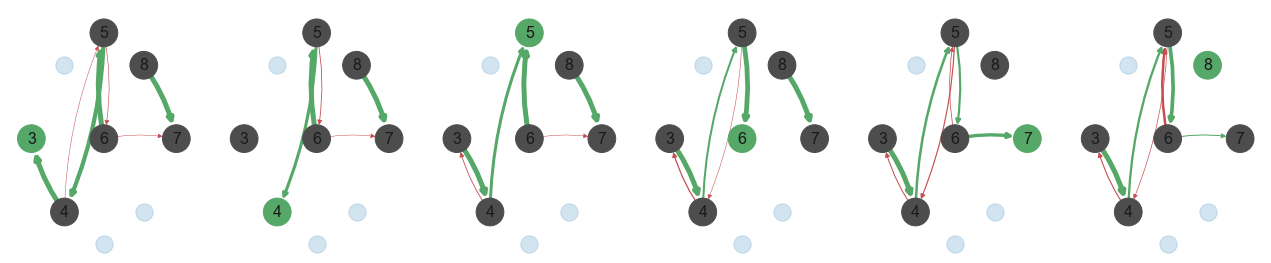

In [324]:
plt.figure(figsize=(18,4))
ctr = 1
for ix in used_rew_cols:
    plt.subplot(1,len(used_rew_cols),ctr)

    c_rew_index = ix  #this is correct, used_rews here are in terms of states

    bad_edges = []
    good_edges = []
    same_edges = []
    good_edges = [[map_state_to_poke(used_states[0]),map_state_to_poke(used_states[1])],
                  [map_state_to_poke(used_states[-1]),map_state_to_poke(used_states[-2])]]

    for s in range(st-2,nd+2):
        if s!=c_rew_index and s in used_states:
            su = s+1 #state_up
            sd = s-1 #state_down
            if lineloop=='loop': 
                if su==used_states[-1]+1:
                    su= used_states[0]
                if sd==used_states[0]-1:
                    sd = used_states[-1]
            d1 = np.abs(c_rew_index-(su))  #distances of state above to reward
            d2 = np.abs(c_rew_index-(sd))  #distance of state below to reward
            
            min_ = np.argmin([d1,d2])
            max_ = np.argmax([d1,d2])

            mn_ = [su,sd][min_]; mx_ = [su,sd][max_]

            if d1==d2:
                if mn_ in used_states:
                    same_edges.append([map_state_to_poke(s),map_state_to_poke(mn_)])

                if mx_ in used_states:
                    same_edges.append([map_state_to_poke(s),map_state_to_poke(mx_)])
            else:
                
                if mn_ in used_states:
                    good_edges.append([map_state_to_poke(s),map_state_to_poke(mn_)])

                if mx_ in used_states:
                    bad_edges.append([map_state_to_poke(s),map_state_to_poke(mx_)])

        

    pos = np.array([1,-1])*poke_pos
    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
    nx.draw(G0,pos=pos,alpha=.2)
    G = nx.DiGraph()
    G.add_nodes_from(sorted(used_pokes))
    weights = []
    
    rew_col = fc[:,ix]
    
    for e in good_edges:
        G.add_edge(e[0],e[1],weight=rew_col[map_poke_to_state(e[0])],color='g')
    for e in bad_edges:
        G.add_edge(e[0],e[1],weight=1-rew_col[map_poke_to_state(e[0])],color='r')
    for e in same_edges:
        print(ctr,map_poke_to_state(e[0]),map_poke_to_state(e[1]))
        G.add_edge(e[0],e[1],weight=rew_col[map_poke_to_state(e[0])],color='.3')

    weights = nx.get_edge_attributes(G,'weight')
    colors = nx.get_edge_attributes(G,'color')
    node_colors = ['.3' for _ in range(len(used_states))]
    
    node_colors[list(G.nodes).index(map_state_to_poke(c_rew_index))] = 'g'
    #node_colors[0] = 'g'
    nx.draw(G,
        pos=pos,
            width=(10**(np.array(list(weights.values()))))/2,
            edge_color=np.array(list(colors.values())),
            connectionstyle="arc3,rad=-0.1",
            node_color=node_colors,
            node_size=768,)
    
    labels = {i:j for i,j in zip(sorted(used_pokes),[map_poke_to_state(i) for i in sorted(used_pokes)])}
    nx.draw_networkx_labels(G, pos, labels, font_size=16)
    #print([map_poke_to_state(i) for j in same_edges for i in j])
    #print(G.node)
    ctr += 1
plt.tight_layout()
#plt.savefig("/Users/yves/Debsktop/tpf/navi_decisions.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_decisions.png",dpi=300)


In [28]:
ROOT = '/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'
fs = sorted([os.path.join(ROOT,i) for i in os.listdir(ROOT) if '.txt' in i])
perf_hist = []
all_fc  = []
all_perf = np.zeros([9,4])
all_ctr = np.zeros([9,4])
for f_ in fs[:-1]:
    try:
        f = open(f_,'r')
        lines =f.readlines()
        experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
        dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

        #poke_to_state_map = get_poke_to_state_map(lines)
        rew_indices = [0,3,5,8]
        perf,perf_ctr = get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=20)

        fc = perf/perf_ctr
        all_perf += perf
        all_ctr += perf_ctr
        all_fc.append(fc)
        perf_hist.append(np.nanmean(fc))
    except:
        pass